# Progetto Machine Learning for Vision and Multimedia

## Prima parte: Conditional GAN per la generazione di segnali stradali russi

### Import

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import random
import copy
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.nn.functional import pad
from torchvision.utils import save_image
from tqdm import tqdm
import tensorflow as tf
import re
#!pip install torch --upgrade
!pip install torchmetrics[image]
!pip install torch-fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
warnings.filterwarnings("ignore", category=UserWarning, message="Metric `InceptionScore` will save all extracted features in buffer.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*os.fork.*")

## Variabili

In [2]:
# Tipi di segnali stradali 
num_classes = 8

# Le immagini verranno ridimensionate a 64x64
dim_immagine = 64
image_size = (64, 64)

# Input rumore
input_dim = 100

# Batch size
batch_size = 128

# Numero canali
channels = 3

n1 = 512

ngpu = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Padding e resize training dataset

In [3]:
class RoadSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB') 

        # Aggiungo padding per rendere l'immagine quadrata
        img = self.pad_to_square(img)

        img = img.resize((dim_immagine,dim_immagine))

        if self.transform:
            img = self.transform(img)

        return img, label

    def pad_to_square(self, img):
        img = img.convert('RGB')
        # Converto l'immagine in un tensore
        img_tensor = transforms.ToTensor()(img)

        # Calcola la dimensione massima tra altezza e larghezza
        max_size = max(img.size)
        (width, height) = img.size

        pad_top = 0
        pad_left = 0
        pad_right = 0
        pad_bottom = 0

        if width >= height:
          padding = (width - height) // 2
          pad_top = padding
          pad_bottom = padding
          if (width - height) % 2 == 1:
            pad_top += 1
        else:
          padding = (-width + height) // 2
          pad_left = padding
          pad_right = padding
          if (-width + height) % 2 == 1:
            pad_left += 1

        # Applica il padding
        img_tensor = pad(img_tensor, (pad_left, pad_right, pad_top, pad_bottom), value=0)

        # Converte il tensore risultante in un'immagine
        img_padded = transforms.ToPILImage()(img_tensor)

        return img_padded

In [4]:
# Path dataset
dataroot='/kaggle/input/russian-road-signs-categories-dataset'

In [5]:
def get_dataset(i):
    transform = transforms.Compose([transforms.Resize(image_size),
                                    #transforms.CenterCrop(image_size),
                                    #transforms.RandomCrop(32, padding=2),
                                    #transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    path_root = dataroot
    
    if i == 0: #caso Training
        path_root = os.path.join(dataroot, "train")
        
    if i == 1: #caso Validation
        path_root = os.path.join(dataroot, "test")

    dataset = RoadSignsDataset(root_dir=path_root, transform=transform)

    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

    return dataset, dataloader

In [6]:
# Ottieni i dataloader per il training e la validazione
train_dataset, train_dataloader = get_dataset(0)  # 0 per il training
val_dataset, val_dataloader = get_dataset(1)  # 1 per la validazione

# Crea un dizionario con i dataloader
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Crea un dizionario con le dimensioni dei dataset
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [7]:
training_size = len(train_dataset)
print(f"Numero totale di immagini nel train_dataset: {training_size}")

Numero totale di immagini nel train_dataset: 56000


In [8]:
# Estrazione di un batch di immagini e label dal dataloader
batch_images, batch_labels = next(iter(train_dataloader))

In [9]:
# Decodifica delle immagini normalizzate
batch_images = batch_images * 0.5 + 0.5  # Reverti la normalizzazione

# Trasformo i tensori in numpy array
batch_images = batch_images.numpy()
batch_labels = batch_labels.numpy()

# Definisco le classi
classes = train_dataset.classes

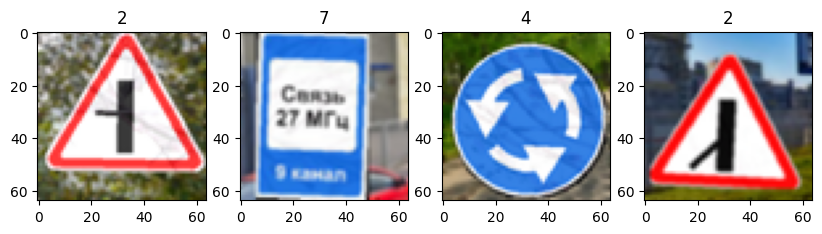

In [10]:
# Stampa di alcune immagini con le relative label
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=4)
for i, ax in enumerate(axes.flat):
    img = batch_images[i].transpose((1, 2, 0))  # Trasposta delle dimensioni per adattarle a matplotlib
    ax.imshow(img)
    ax.set_title(classes[batch_labels[i]])
    ax.axis('on')  # Mostro gli assi delle immagini

plt.show()

In [11]:
def plot_figures(x, n):
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(x.to(device)[:n], padding=2, normalize=True).cpu(),(1,2,0)))

    plt.show()

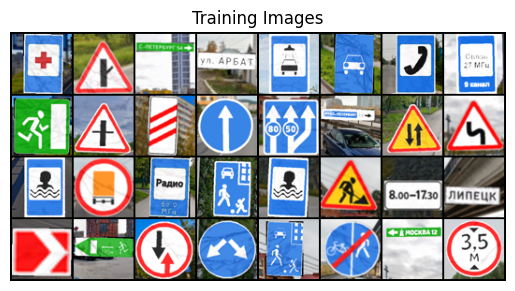

In [12]:
# Plot di alcune immagini del training
images, _ = next(iter(train_dataloader))
plt.title("Training Images")
plot_figures(images, 32)

# Generatore

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, n1, channels, num_classes, width, height):
        super(Generator, self).__init__()
        self.dim1 = width // 16
        self.dim2 = height // 16
        self.n1 = n1

        # Embedding per le etichette
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Linear layer per trasformare il rumore (dimensione piatta)
        self.fc_noise = nn.Linear(input_dim, self.dim1 * self.dim2 * n1)

        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(n1 + num_classes, n1 // 2, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(n1 // 2),
            nn.ConvTranspose2d(n1 // 2, n1 // 4, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n1 // 4),
            nn.ConvTranspose2d(n1 // 4, n1 // 8, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n1 // 8),
            nn.ConvTranspose2d(n1 // 8, channels, kernel_size=5, stride=2, padding=0),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Embedding labels e ridimensionamento con unsqueeze per concatenarle con il rumore
        label_embedding = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        
        # Appiattisci il rumore per passarlo attraverso la rete fully connected
        noise = noise.view(noise.size(0), -1)  # (batch_size, input_dim)
        noise = self.fc_noise(noise).view(-1, self.n1, self.dim1, self.dim2)

        # Concatenare lungo i canali (dim=1)
        x = torch.cat([noise, label_embedding.expand(-1, -1, self.dim1, self.dim2)], dim=1)
        x = self.conv_transpose(x)

        return x

# Discriminatore

In [14]:
class Discriminator(nn.Module):
    def __init__(self, width, height, channels, num_classes):
        super(Discriminator, self).__init__()
        input_shape = (channels, width, height)

        self.leaky = nn.LeakyReLU(0.2)
        n1 = 128
        n2 = 256
        n3 = 512

        # Embedding per le etichette
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels + num_classes, n1, kernel_size=5, stride=2),
            self.leaky,
            nn.Conv2d(n1, n2, kernel_size=5, stride=2),
            self.leaky,
            nn.Conv2d(n2, n3, kernel_size=3, stride=2),
            self.leaky,
        )

        # Calcolo dimensioni output del layer conv
        input_tensor = torch.randn(1, channels + num_classes, height, width)
        conv_output = self.conv_layers(input_tensor)
        conv_output_dim = conv_output.view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(conv_output_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embedding labels e ridimensionamento con unsqueeze per concatenarle all'immagine
        label_embedding = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)

        # Concatenare lungo i canali (dim=1)
        x = torch.cat([img, label_embedding.expand(-1, -1, img.size(2), img.size(3))], dim=1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)

        return x

## Inizializzazione pesi

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gaussian(ins, mean, stddev):
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise

In [16]:
netG = Generator(input_dim, n1, channels, num_classes, image_size[0], image_size[1]).to(device)
netD = Discriminator(image_size[0], image_size[1], channels, num_classes).to(device)

# Inizializzo tutti i pesi a media 0 e deviazione standard 0.2
netG.apply(weights_init)
netD.apply(weights_init)

# Print dei modelli
print(netG)
print(netD)

Generator(
  (label_embedding): Embedding(8, 8)
  (fc_noise): Linear(in_features=100, out_features=8192, bias=True)
  (conv_transpose): Sequential(
    (0): ConvTranspose2d(520, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2, 2))
    (10): Tanh()
  )
)
Discriminator(
  (leaky): LeakyReLU(negative_slope=0.2)
  (label_embedding): Embedding(8, 8)
  (conv_layers): Sequential(
    (0): Conv2d(11, 128, kernel_size=(5, 5), stride=(2, 2))
    (1

In [17]:
# Learning rate
lr = 0.0002

# Parametri per ottimizzatore Adam
beta1 = 0.5
beta2 = 0.9

# Ottimizzatori
optimizerG = optim.Adam(netG.parameters(), lr=lr/2, betas=(beta1, beta2))
optimizerD = optim.Adam(netD.parameters(), lr=lr*2, betas=(beta1, beta2))

# Funzione loss
criterion = nn.BCELoss()

# Etichette reali e false
real_label = 1
fake_label = 0

In [18]:
# Per salvare le immagini generate durante la fase di training una per una
gen_img_save_path='/kaggle/working/generated_img'
os.makedirs(gen_img_save_path, exist_ok=True)

# Per salvare grafici e batch di immagini in fase di training
plot_save_training_path = '/kaggle/working/plot_images'
os.makedirs(plot_save_training_path, exist_ok=True)

# Fase di training

In [19]:
# Funzione per calcolare le metriche di classificazione
def calculate_classification_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy, precision, recall, f1

In [20]:
# Funzione per tracciare e salvare le curve di perdita del Generatore e del Discriminatore
def plot_and_save_losses(G_losses, D_losses, epoch, plot_save_training_path):
    plt.figure(figsize=(10, 5))
    plt.title("Loss del Generatore e del Discriminatore durante il training")
    plt.plot(G_losses, label="Generatore")
    plt.plot(D_losses, label="Discriminatore")
    plt.xlabel("Iterazioni")
    plt.ylabel("Loss")
    plt.legend()

    # Salvataggio del grafico
    loss_plot_path = os.path.join(plot_save_training_path, f'epoch_{epoch}_loss_plot.png')
    plt.savefig(loss_plot_path)
    print(f"Loss plot saved at {loss_plot_path}")
    
#-----------------------------------------------------------------------

# Funzione per tracciare e salvare le metriche di performance
def plot_and_save_metrics(vec_acc, vec_rec, vec_prec, vec_f1, vec_fid, vec_inc_sc, epoch, plot_save_training_path):
    metrics = {
        'Accuracy': vec_acc,
        'Recall': vec_rec,
        'Precision': vec_prec,
        'F1-Score': vec_f1,
        'FID': vec_fid,
    }
    
    for metric_name, metric_values in metrics.items():
        if metric_name == 'fid':
            plt.figure(figsize=(10, 5))
            plt.title(f"{metric_name} during training")
            plt.plot(metric_values, label=metric_name)
            plt.xlabel("Epoch")
            plt.ylabel(metric_name)
            plt.legend()

            # Salvataggio del grafico
            metric_plot_path = os.path.join(plot_save_training_path, f'epoch_{epoch}_{metric_name.lower().replace(" ", "_")}_plot.png')
            plt.savefig(metric_plot_path)
            print(f"{metric_name} plot saved at {metric_plot_path}")

In [21]:
# Inizializzazione FID e Inception Score
fid = FrechetInceptionDistance(feature=64).to(device)
inception_score = InceptionScore(feature=64).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 295MB/s]


Checkpoint found: checkpoint_epoch_140.pth. Resuming training from epoch 141
Starting Training Loop...


Epoch 141: 100%|██████████| 438/438 [02:11<00:00,  3.32it/s]


[Epoch 141]	Loss_D: 0.1927	Loss_G: 6.8659	D(x): 0.9862	D(G(z)): 0.0779 / 0.0075	FID: 12.1107	Inception Score: 1.1642 (std: 0.0012)
Loss plot saved at /kaggle/working/plot_images/epoch_141_loss_plot.png


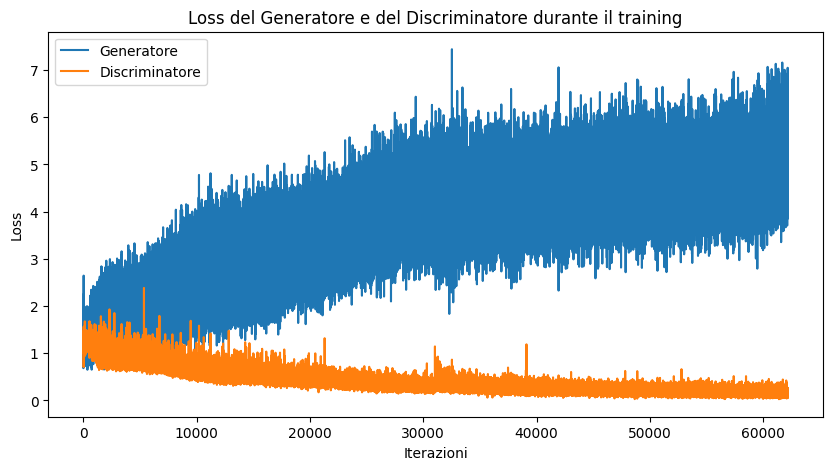

In [35]:
# Numero di epoche di allenamento
num_epochs = 1

# Funzione per trovare il checkpoint con il numero più alto
def find_latest_checkpoint():
    checkpoints = glob.glob('checkpoint_epoch_*.pth')
    if not checkpoints:
        return None
    
    # Estrae il numero dai nomi dei file e trova il massimo
    max_checkpoint = max(checkpoints, key=lambda x: int(re.findall(r'\d+', x)[0]))
    return max_checkpoint

# Caricamento dell'ultimo checkpoint (se esiste)
#latest_checkpoint_path = '/kaggle/input/chp-110/checkpoint_epoch_110.pth'
latest_checkpoint_path = find_latest_checkpoint()
if latest_checkpoint_path:
    try:
        # Carica il checkpoint sulla CPU per evitare errori di dispositivi
        checkpoint = torch.load(latest_checkpoint_path, map_location=torch.device('cpu'), weights_only=False)
        
        # Carica i parametri del generatore, discriminatore e ottimizzatori
        netG.load_state_dict(checkpoint['generator_state_dict'])
        netD.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizerG.load_state_dict(checkpoint['generator_optimizer_state_dict'])
        optimizerD.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
        
        # Carica le metriche salvate
        G_losses = checkpoint['G_losses']
        D_losses = checkpoint['D_losses']
        img_list = checkpoint['img_list']
        vec_acc = checkpoint['vec_acc']
        vec_rec = checkpoint['vec_rec']
        vec_prec = checkpoint['vec_prec']
        vec_f1 = checkpoint['vec_f1']
        vec_fid = checkpoint['vec_fid']
        vec_inc_sc = checkpoint['vec_inc_sc']
        D_x = checkpoint['D_x']
        iters = checkpoint['iters']
        start_epoch = checkpoint['epoch'] + 1  # Riprende dall'epoca successiva
        
        # Crea un rumore fisso per il generatore (utile per visualizzare risultati consistenti)
        fixed_noise = checkpoint.get('fixed_noise', torch.randn(batch_size, input_dim, 1, 1, device=device))
        fixed_label = checkpoint.get('fixed_label', torch.randint(0, num_classes, (batch_size,), device=device, dtype=torch.long))
        
        print(f"Checkpoint found: {latest_checkpoint_path}. Resuming training from epoch", start_epoch)
    
    except (RuntimeError, FileNotFoundError, KeyError) as e:
        print("Error loading checkpoint:", e)
        print("No valid checkpoint found. Starting training from scratch.")
        
        # Inizializzazione da zero in caso di errore o assenza di checkpoint
        start_epoch = 0
        iters = 0
        G_losses, D_losses, img_list = [], [], []
        vec_acc, vec_rec, vec_prec, vec_f1, vec_fid, vec_inc_sc = [], [], [], [], [], []
        D_x = 0
        fixed_noise = torch.randn(batch_size, input_dim, 1, 1, device=device)
        fixed_label = torch.randint(0, num_classes, (batch_size,), device=device, dtype=torch.long)
else:
    print("No checkpoint found. Starting training from scratch.")
    
    # Inizializzazione da zero se nessun checkpoint è disponibile
    start_epoch = 0
    iters = 0
    G_losses, D_losses, img_list = [], [], []
    vec_acc, vec_rec, vec_prec, vec_f1, vec_fid, vec_inc_sc = [], [], [], [], [], []
    D_x = 0
    fixed_noise = torch.randn(batch_size, input_dim, 1, 1, device=device)
    fixed_label = torch.randint(0, num_classes, (batch_size,), device=device, dtype=torch.long)


# Ciclo di allenamento
print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs + start_epoch):
    
    all_real_labels = []
    all_predicted_labels = []
    
    # Aggiungo una barra di progresso per ogni batch
    for i, (data, real_style_labels) in enumerate(tqdm(train_dataloader, leave=True, desc=f'Epoch {epoch}')):
        
        # 1: Aggiornamento del Discriminatore: occorre massimizzare log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()
        real_cpu = data.to(device)
        real_style_labels = real_style_labels.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        fake_style_labels = torch.tensor(np.random.choice(num_classes, size=b_size)).type(torch.LongTensor).to(device)
        
        # Passaggio del batch reale attraverso il discriminatore
        output = netD(gaussian(real_cpu, mean=0, stddev=0.5 * 0.01 ** (epoch / num_epochs)), real_style_labels).view(-1)
        errD_real = criterion(output, label)
        
        # Gradiente
        errD_real.backward()
        D_x = output.mean().item()

        # Allenamento con batch finto
        noise = torch.randn(b_size, input_dim, 1, 1, device=device)
        fake = netG(noise, fake_style_labels)
        label.fill_(fake_label)
        output = netD(fake.detach(), fake_style_labels).view(-1)
        
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 2: Aggiornamento del Generatore: occorre massimizzare log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, fake_style_labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        
        # Salva le perdite per il grafico
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Raccoglie etichette per le metriche di classificazione
        all_real_labels.extend(real_style_labels.cpu().numpy())
        all_predicted_labels.extend(output.detach().cpu().round().numpy())

        # Aggiorna FID e Inception Score
        real_cpu_uint8 = (real_cpu * 255).byte()  # Convert to uint8
        fake_uint8 = (fake * 255).byte()  # Convert to uint8
        fid.update(real_cpu_uint8, real=True)
        fid.update(fake_uint8, real=False)
        inception_score.update(fake_uint8)
        
        # Salvataggio delle immagini generate alla fine di ogni batch
        if i == len(train_dataloader) - 1:
            with torch.no_grad():
                fixed_noise = fixed_noise.to(device)
                fixed_label = fixed_label.to(device)
                fake = netG(fixed_noise, fixed_label).detach().cpu()
            
            img_list.append(vutils.make_grid(fake[:32], nrow=8, padding=2, normalize=True))
            save_image(fake[:32].data, os.path.join(plot_save_training_path, f'{epoch}-{iters}.png'), nrow=8, normalize=True)

        iters += 1
    
    # Calcolo delle metriche di classificazione dopo ogni epoca
    accuracy, precision, recall, f1 = calculate_classification_metrics(all_real_labels, all_predicted_labels)
    vec_acc.append(accuracy)
    vec_prec.append(precision)
    vec_rec.append(recall)
    vec_f1.append(f1)
    
    # Calcolo delle metriche FID e Inception Score
    fid_score = fid.compute().item()
    inception_mean, inception_std = inception_score.compute()
    vec_fid.append(fid_score)
    vec_inc_sc.append((inception_mean.item(), inception_std.item()))
    
    # Statistiche di allenamento alla fine di ogni epoca
    #print('[Epoch %d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tAccuracy: %.4f\tPrecision: %.4f\tRecall: %.4f\tF1: %.4f\tFID: %.4f\tInception Score: %.4f (std: %.4f)'
          #% (epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, accuracy, precision, recall, f1, fid_score, inception_mean, inception_std))
    print('[Epoch %d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tFID: %.4f\tInception Score: %.4f (std: %.4f)'
      % (epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, fid_score, inception_mean, inception_std))

    # Reset delle metriche per l'epoca successiva
    fid.reset()
    inception_score.reset()
    
    # Grafici e salvataggio ogni 30 epoche
    if epoch % 30 == 0:
        plot_and_save_losses(G_losses, D_losses, epoch, plot_save_training_path)
        plot_and_save_metrics(vec_acc, vec_rec, vec_prec, vec_f1, vec_fid, vec_inc_sc, epoch, plot_save_training_path)

    # Mostra a video immagini generate ogni 10 epoche e salvataggio del checkpoint
    if epoch % 10 == 0:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Immagini generate - Epoch {}".format(epoch))
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
        plt.show()

        # Salvataggio del checkpoint ogni 10 epoche
        checkpoint_path = f'checkpoint_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'generator_state_dict': netG.state_dict(),
            'discriminator_state_dict': netD.state_dict(),
            'generator_optimizer_state_dict': optimizerG.state_dict(),
            'discriminator_optimizer_state_dict': optimizerD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'img_list': img_list,
            'D_x': D_x,
            'iters': iters,
            'fixed_noise': fixed_noise,
            'fixed_label': fixed_label,
            'vec_acc': vec_acc,
            'vec_prec': vec_prec,
            'vec_rec': vec_rec,
            'vec_f1': vec_f1,
            'vec_fid': vec_fid,
            'vec_inc_sc': vec_inc_sc,
        }, checkpoint_path)
        
        print(f"Checkpoint saved: {checkpoint_path}")
        
    # Per salvare le immagini generate durante la fase di training una per una ogni 50 epoche
    if (epoch % 50) == 0:
        
        save_epoch_path = os.path.join(gen_img_save_path, f'epoch_{epoch}')
        os.makedirs(save_epoch_path, exist_ok=True)                
    
        # Salvataggio immagini
        with torch.no_grad():
            for i in range(batch_size):
                noise = torch.randn(1, input_dim, 1, 1, device=device)
                label = torch.randint(0, num_classes, (1,), device=device)
                fake = netG(noise, label).detach().cpu()
                label_str = classes[label.item()]  # Ottiengo il nome della classe

                # Converto le immagini generate in vettori numpy per visualizzarle
                img = fake[0].numpy().transpose((1, 2, 0))  # Converte CHW a HWC
                img = (img + 1) / 2  # Denormalize to [0, 1]

                save_image(fake[0], os.path.join(save_epoch_path, f'image_{i}_{label_str}.png'), normalize=True)

        print(f"Generated images saved for epoch {epoch} at {save_epoch_path}")

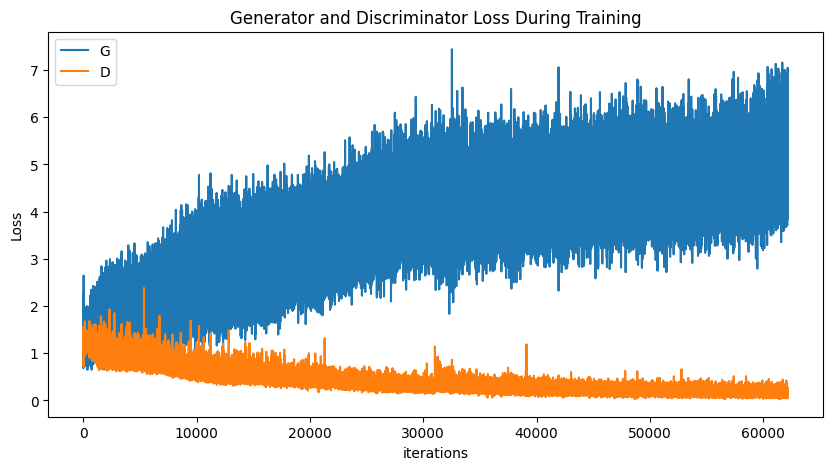

In [45]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

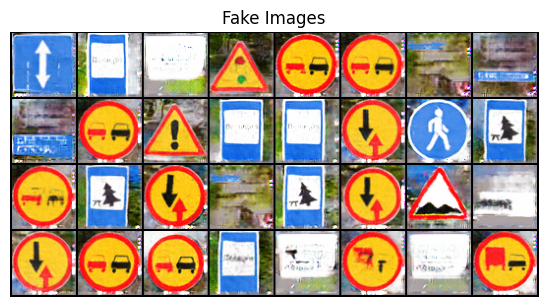

In [46]:
# Plot delle immagini generate dell'ultima epoca
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Confronto tra immagini reali e immagini generate

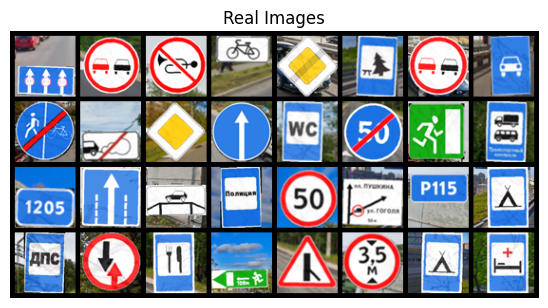

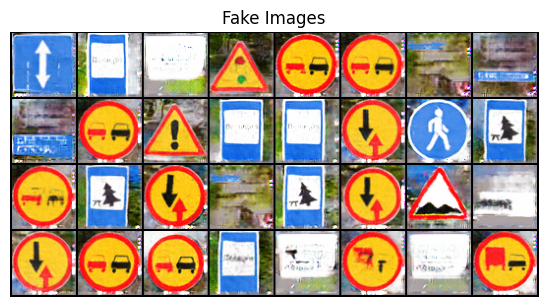

In [47]:
real_batch = next(iter(train_dataloader))

# Immagini reali
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Immagini generate
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Stampo un'immagine per ogni label

In [51]:
# Funzione per mappare i codici ai nomi dei segnali
def mapping_signs(code_s):
    code = int(code_s)
    if code == 1:
        return "Pericolo"
    elif code == 2:
        return "Priorità"
    elif code == 3:
        return "Divieto"
    elif code == 4:
        return "Obbligo"
    elif code == 5:
        return "Regolamentazione"
    elif code == 6:
        return "Informazione"
    elif code == 7:
        return "Servizi"
    elif code == 8:
        return "Pannelli integrativi"
    else:
        return "Non trovato"

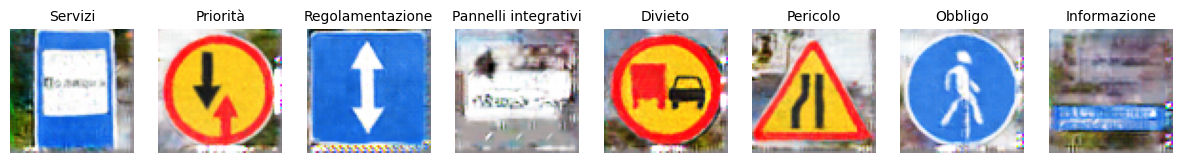

In [52]:
# Elenco classi
classes = train_dataset.classes
#print(f"Elenco classi: {classes}")

fixed_noise = torch.randn(num_classes, input_dim, 1, 1, device=device) 
fixed_labels = torch.tensor([i for i in range(num_classes)], dtype=torch.long, device=device)

# Genera le immagini con il generatore
with torch.no_grad():
    final_fake_images = netG(fixed_noise, fixed_labels).detach().cpu()

# Imposta la figura per visualizzare le immagini
fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))

for i in range(num_classes):
    # Estrai l'immagine corrispondente
    img = final_fake_images[i]
    
    # Trasforma l'immagine in formato numpy per la visualizzazione con matplotlib
    img_np = np.transpose(vutils.make_grid(img, padding=2, normalize=True), (1, 2, 0))
    
    # Visualizza l'immagine nel subplot
    axes[i].imshow(img_np)
    axes[i].axis("off")  # Rimuove gli assi
    
    # Mappa la classe corrispondente al nome
    class_name = mapping_signs(classes[i])
    
    # Imposta il titolo con il nome della classe corrispondente
    axes[i].set_title(f"{class_name}", fontsize=10)
plt.show()

### Per vedere più immagini della stessa label:

In [54]:
def generate_images_per_label(generator, num_classes, num_images_per_class, device):
    generator.eval()
    all_generated_images = []
    for label in range(num_classes):
        noise = torch.randn(num_images_per_class, input_dim, device=device)
        labels = torch.full((num_images_per_class,), label, dtype=torch.long, device=device)
        with torch.no_grad():
            generated_images = generator(noise, labels)
        all_generated_images.append(generated_images.cpu())
    return all_generated_images

def prepare_images_for_plotting(images_list, num_images_per_class, image_size):
    all_images = []
    for images in images_list:
        images = (images + 1) / 2  # Normalizza le immagini tra 0 e 1
        all_images.append(images)
    return all_images

def plot_images_by_label(images_by_label, num_images_per_class, num_classes):
    
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    plt.figure(figsize=(8, 8))
    for label in range(num_classes):
        for img_idx in range(num_images_per_class):
            axs[label, img_idx].imshow(images_by_label[label][img_idx].permute(1, 2, 0))
            axs[label, img_idx].axis('off')
            class_name = mapping_signs(train_dataset.classes[label])
            axs[label, img_idx].set_title(f'{class_name}', fontsize=10)            
    plt.tight_layout()
    plt.show()

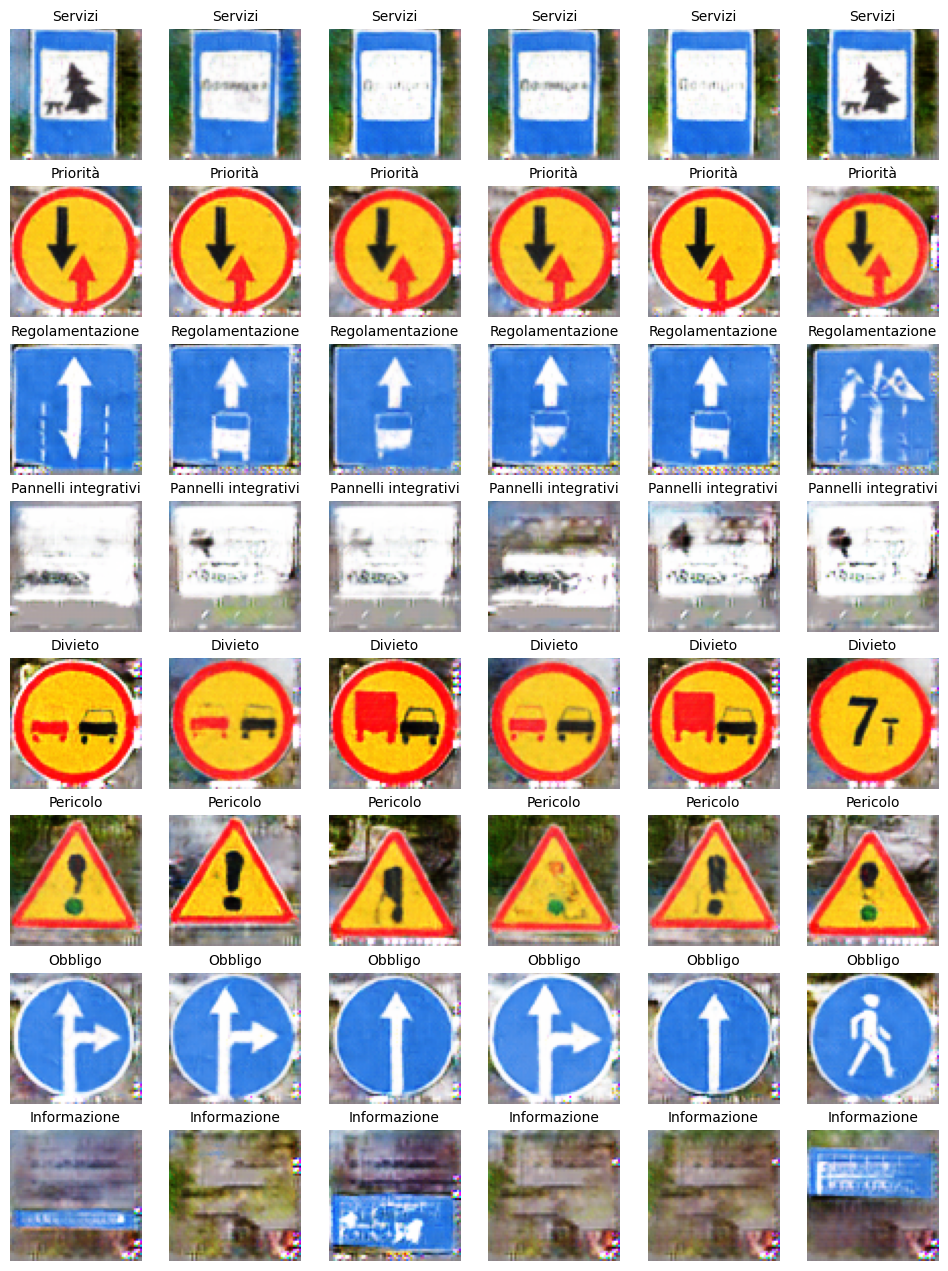

<Figure size 800x800 with 0 Axes>

In [55]:
num_images_per_class = 6  # Numero di immagini per ogni etichetta
generated_images_by_label = generate_images_per_label(netG, num_classes, num_images_per_class, device)
prepared_images = prepare_images_for_plotting(generated_images_by_label, num_images_per_class, image_size)
plot_images_by_label(prepared_images, num_images_per_class, num_classes)

### Set di immagini casuali

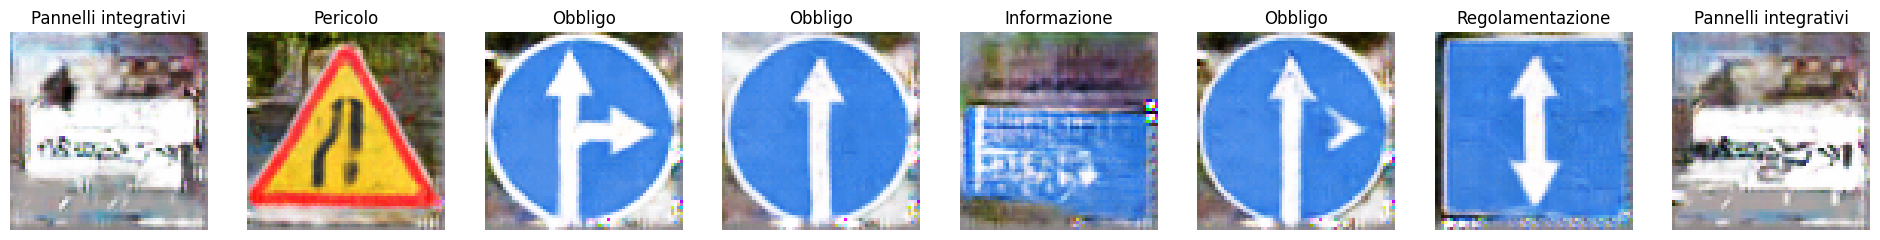

In [56]:
# Funzione per generare e visualizzare immagini casuali con le rispettive etichette
def generate_and_display_random_images(generator, num_images, num_classes, noise_dim, class_names, device='cuda'):
    generator.eval()  # Imposta il generatore in modalità di valutazione
    
    # Crea un batch di rumore casuale
    noise = torch.randn(num_images, noise_dim, 1, 1, device=device)
    
    # Crea un batch di etichette casuali
    random_labels = torch.randint(0, num_classes, (num_images,), device=device)
    
    # Genera immagini condizionate dalle etichette casuali
    with torch.no_grad():
        generated_images = generator(noise, random_labels).detach().cpu()

    # Visualizza le immagini generate insieme alle etichette
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    
    for i in range(num_images):
        img = generated_images[i].permute(1, 2, 0)
        img = img * 0.5 + 0.5 
        
        axs[i].imshow(img)
        class_name = mapping_signs(class_names[random_labels[i].item()])
        axs[i].set_title(f'{class_name}')  # Mostra il nome della classe
        axs[i].axis('off')  # Rimuove gli assi

    plt.show()

# Genera e visualizza num_images immagini casuali utilizzando i nomi delle classi
generate_and_display_random_images(netG, num_images=8, num_classes=num_classes, noise_dim=input_dim, class_names=train_dataset.classes, device=device)
